In [ ]:
import zipfile
import os
import glob
import json
import re
from os import path
from io import open
import glob
from collections import Counter
from __future__ import unicode_literals, print_function, division
from google.colab import files, auth, drive
from torch.optim.lr_scheduler import LambdaLR
from urllib.request import urlopen
from typing import List, Dict, Callable
import math
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import RandomSampler, Sampler
from torch import nn, Tensor
from torch.optim import SGD, Adam
import unicodedata
import random
import string
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Dataset.zip", 'r')
zip_ref.extractall("tmp")
zip_ref.close()

train_path = 'tmp/train-data-split/'
test_path = 'tmp/test-data-split/'

In [4]:
os.rename(train_path+'1c11a25f50b0b324cdd8732ba7a7e880b081b543index_2.mov', train_path+'1c11a25f50b0b324cdd8732ba7a7e880b081b543index_2')
os.rename(train_path+'b89fe67d4acab4275fcd213af5770b9ba6a1f124data_silo-update_insert_0', train_path+'b89fe67d4acab4275fcd213af5770b9ba6a1f124data_silo-update&insert_0')
os.rename(train_path+'9604d6d43c4afd528fb4a30efb1183fb66c9ff6dAFTER_INSERT_basic_0', train_path+'9604d6d43c4afd528fb4a30efb1183fb66c9ff6dAFTER|INSERT|basic_0')

#print( open('/content/drive/MyDrive/DeepLearn tema 3/train-data-split/1c11a25f50b0b324cdd8732ba7a7e880b081b543index_2').read() )
#print( open('/content/drive/MyDrive/DeepLearn tema 3/train-data-split/b89fe67d4acab4275fcd213af5770b9ba6a1f124data_silo-update&insert_0').read() )
#print( open(train_path+'9604d6d43c4afd528fb4a30efb1183fb66c9ff6dAFTER|INSERT|basic_0').read() )

In [5]:
train_dict = json.load(open('tmp/code-train-gt.json'))
test_dict = json.load(open('tmp/code-test-gt.json'))

print( len(train_dict))
print( len(test_dict))

from tqdm import tqdm
x_train = [open(train_path+file_path).read() for file_path in tqdm(list(train_dict.keys()))]

label_dict = {}
for idx,label in enumerate(list(set(train_dict.values()))):
  label_dict[label] = idx
  label_dict[idx] = label
y_train = [label_dict[label] for label in list(train_dict.values())]

11103
2995


100%|██████████| 11103/11103 [00:00<00:00, 26781.51it/s]


In [6]:
test_data = [ open(test_path+file_path).read() for file_path in list(test_dict.keys())]
test_labels = list(test_dict.values())

In [7]:

train_data, val_data, train_labels, val_labels = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print( len(train_data) )
print( len(val_data) )

8882
2221


In [8]:
class Vocabulary:
    """
    Helper class that maps characters to unique indices and the other way around
    """
    def __init__(self, text: str):
        characters_set = set(['<UNK>', '<PAD>']) 
        word_set = set(['<UNK>', '<PAD>']) 
        
        characters_set.update(text)
        word_set.update( re.findall(r'\b\w+\b|[^\w\s]', text) )
        
        self.char_to_idx = {char:idx for (idx, char) 
                            in enumerate(characters_set)}
        self.idx_to_char = {idx:char for (idx, char) 
                            in enumerate(characters_set)}

        self.word_to_idx = {word:idx for (idx, word)
                            in enumerate(word_set)}
        self.idx_to_word = {idx:word for (idx, word)
                            in enumerate(word_set)}
   
   
    def size(self):
        return len(self.word_to_idx)

    def __str__(self):
        return str(self.word_to_idx)

#vocab = Vocabulary(string.printable)
#vocab = Vocabulary(''.join([chr(i) for i in range(256)]))
vocab = Vocabulary(''.join(train_data))

print("Vocabulary size: ", vocab.size())
print("Vocabulary: \n", vocab)

#for code_snippet in train_data:


Vocabulary size:  92521


In [153]:
def text_to_tensor(text: str, vocab: Vocabulary) -> torch.LongTensor:

    text_indices = []

    for c in re.findall(r'\b\w+\b|[^\w\s]', text):
      if c in vocab.word_to_idx:
        text_indices.append(vocab.word_to_idx[c])
      else: text_indices.append(vocab.word_to_idx['<UNK>'])
    
    return torch.tensor(text_indices)
  
def tensor_to_text(x: torch.LongTensor, vocab: Vocabulary) -> str:

    return " ".join(vocab.idx_to_word[idx.item()] for idx in x)

def batch_tensor_to_text(x: torch.LongTensor, vocab: Vocabulary) -> List[str]:

    assert len(x.size()) == 2, "wrong number of dimensions (should be 2)"
    outputs = []
    for batch_idx in range(len(x)):
        outputs.append(tensor_to_text(x[batch_idx], vocab))
            
    return outputs 

# setup device (CPU/GPU)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')


In [155]:
print( tensor_to_text( text_to_tensor(train_data[0], vocab), vocab) )


namespace InstrumentApp class FindInstrumentTester { public static void testInstrumentSearch ( ) { Inventory inventory = new Inventory ( ) ; initializeInventory ( inventory ) ; Dictionary < string , object > guitarSpec = new Dictionary < string , object > { { " instrumentType " , InstrumentType . Guitar } , { " builder " , Builder . Fender } , { " model " , " Stratocastor " } , { " type " , Type . electric } , { " topWood " , Wood . Alder } , { " backWood " , Wood . Adirondack } , { " numStrings " , 6 }


In [157]:
len(train_data)


8882

In [158]:
def batch_generator(train_data, train_labels, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    batch = []
    labels = []
    train_x, train_y = shuffle(train_data, train_labels, random_state = 42)
    for (text,label) in zip(train_data, train_labels):
      tokenized = text_to_tensor(text, vocab)
      #print( tokenized.shape )

      if len(tokenized) > token_size:
        tokenized = tokenized[:token_size]
      else:
        padding_size = token_size-len(tokenized)
        tokenized = torch.cat([tokenized, torch.tensor([vocab.word_to_idx['<UNK>']] * padding_size, dtype=torch.int64)] )

      batch.append( tokenized )
      labels.append( label )

      if isinstance( batch[-1] , int ):
        print( text, label )

      if len(batch) == batch_size:
        yield (batch,labels)
        batch = []
        labels = []

    if len(batch):
      yield (batch,labels)
      batch = []
      labels = []

In [159]:
# ############################## PARAMETERS ######################################
learning_rate = 0.001
rnn_model = 'gru'
rnn_layers = 1

_hyperparameters_dict = {
    "batch_size": 32,
    "num_epochs": 20,
    "max_len": 256,
    "embedding_size": 200, 
    "hidden_size": 256,
    "rnn_layers": rnn_layers,
    "rnn_model": rnn_model,
    "bidirectional": True,
    "learning_algo": "adam",
    "learning_rate": learning_rate,
    "dropout": 0.2,
    "max_grad_norm": 10.0
}

#for character embedding
# _hyperparameters_dict = {
#     "batch_size": 32,
#     "num_epochs": 20,
#     "max_len": 250,
#     "embedding_size": 100, 
#     "hidden_size": 256,
#     "rnn_layers": rnn_layers,
#     "rnn_model": rnn_model,
#     "bidirectional": True,
#     "learning_algo": "adam",
#     "learning_rate": learning_rate,
#     "dropout": 0.4,
#     "weight_decay": 0.01,
#     "max_grad_norm": 5.0
# }

In [161]:
class RNNClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, num_classes, rnn='gru', bidirectional=False):
    super().__init__()
    self.vocab_size = vocab_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    
    self.embedding = nn.Embedding(num_embeddings = vocab_size, 
                                  embedding_dim = embedding_size)
        
    
    if rnn == "gru":
      self.rnn_model = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
    elif rnn =="lstm":
      self.rnn_model = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
    else: self.rnn_model = nn.RNN(embedding_size, hidden_size, num_layers, bidirectional=bidirectional) 
    
    self.dropout = nn.Dropout(p=_hyperparameters_dict["dropout"])

    if bidirectional == False:
      self.output_layer = nn.Linear( hidden_size, num_classes)
    else:
       self.output_layer = nn.Linear( hidden_size*2, num_classes)

  def forward(self, x, h=None):
  
    encoded = self.embedding(x)
    
    hidden_states, _ = self.rnn_model(encoded, h)
    
    dropout_hidden_states = self.dropout(hidden_states)
    out = self.output_layer(dropout_hidden_states)  
    
    predictions = torch.mean(out,dim=1)
    predictions = nn.Softmax(dim=1)(predictions)

    return predictions

In [162]:
num_classes = 6
network = RNNClassifier(vocab.size(),
                          _hyperparameters_dict["embedding_size"],
                          _hyperparameters_dict["hidden_size"],
                          _hyperparameters_dict["rnn_layers"],
                          num_classes,
                          _hyperparameters_dict["rnn_model"],
                          _hyperparameters_dict["bidirectional"])

network = network.to(device)

criterion = nn.CrossEntropyLoss()

In [163]:
network.train()

RNNClassifier(
  (embedding): Embedding(92521, 200)
  (rnn_model): GRU(200, 256, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=512, out_features=6, bias=True)
)

In [164]:
set(train_labels)

{0, 1, 2, 3, 4, 5}

In [165]:
class Trainer:
    def __init__(self, model: nn.Module, 
                 train_data: torch.LongTensor, 
                 train_labels: torch.LongTensor,
                 val_data: torch.LongTensor,
                 val_labels: torch.LongTensor,
                 vocab: Vocabulary, 
                 hyperparams: Dict):
        self.model = model
        self.train_data = train_data
        self.val_data = val_data
        self.train_labels = train_labels
        self.val_labels = val_labels
        self.vocab = vocab
        if hyperparams['learning_algo'] == 'adam':
            self.optimizer = Adam(params = self.model.parameters(),
                                  lr = hyperparams['learning_rate'])
        else:
            self.optimizer = SGD(params = self.model.parameters(), 
                                 lr = hyperparams['learning_rate'])
            
        self.num_epochs = hyperparams['num_epochs']
        self.max_len = hyperparams['max_len']
        self.batch_size = hyperparams['batch_size']
        self.hidden_size = hyperparams['hidden_size']
        self.max_grad_norm = hyperparams['max_grad_norm']
        
        #number of characters in training/dev data
        self.train_size = len(train_data)
        self.val_size = len(val_data)
        
    def train_epoch(self, epoch_num: int) -> float:
        """
        Compute the loss on the training set
        :param epoch_num: number of current epoch
        """
        self.model.train()
        epoch_loss = 0.0

        predicted_labels = []

        for batch_num, batch in enumerate(batch_generator(self.train_data, self.train_labels,
                                                          self.batch_size, self.max_len)):
            #print( batch_num)
            X = torch.stack( batch[0]).to(device) 
            Y = torch.tensor( batch[1]).to(device)
            # reset gradients
            self.optimizer.zero_grad()

            output = self.model(X)

            predicted_labels += output.argmax(dim=1).tolist()

            batch_loss = criterion( output, Y )
            batch_loss.backward()
            
            # clip gradients if they get too large
            torch.nn.utils.clip_grad_norm_(list(self.model.parameters()), 
                                           self.max_grad_norm)
            
            # update parameters
            self.optimizer.step()

            epoch_loss += batch_loss.item()
            batch_accuracy = accuracy_score( batch[1], output.argmax(dim=1).tolist() )

            #if batch_num % 10 == 0:
                #print("epoch %d, batch %d, batch loss = %f, batch accuracy = %f"
                #      % (epoch_num, batch_num+1, 
                #         batch_loss.item(), batch_accuracy))
   
        epoch_loss /= (batch_num + 1)
        
        epoch_accuracy = accuracy_score(self.train_labels, predicted_labels)
        return epoch_loss, epoch_accuracy

    def eval_epoch(self, epoch_num: int) -> float:
        """
        Compute the loss on the validation set
        :param epoch_num: number of current epoch
        """
        epoch_loss = 0.0
        self.model.eval()

        predicted_labels = []
        with torch.no_grad():
           for batch_num, batch in enumerate(batch_generator(self.val_data, self.val_labels,
                                                          self.batch_size, self.max_len)):
                X = torch.stack( batch[0]).to(device) 
                Y = torch.tensor( batch[1]).to(device)

                output = self.model(X)
                
                predicted_labels += output.argmax(dim=1).tolist()

                batch_loss = criterion( output, Y )
                epoch_loss += batch_loss.item()

        epoch_loss /= (batch_num + 1)
        
        epoch_accuracy = accuracy_score(self.val_labels, predicted_labels)
        return epoch_loss, epoch_accuracy   
            
    def train(self) -> Dict:
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        for epoch in range(self.num_epochs):
            epoch_train_loss, epoch_train_accuracy = self.train_epoch(epoch)
            epoch_val_loss, epoch_val_accuracy = self.eval_epoch(epoch)
            train_losses.append(epoch_train_loss)
            val_losses.append(epoch_val_loss)
            train_accuracies.append(epoch_train_accuracy)
            val_accuracies.append(epoch_val_accuracy)
            print("epoch %d, train loss %f, val loss = %f, train accuracy = %f, val accuracy = %f"
                     % (epoch, epoch_train_loss, epoch_val_loss, 
                        epoch_train_accuracy, epoch_val_accuracy))
        return {"train_losses": train_losses,
                "val_losses": val_losses,
                "train_accuracies": train_accuracies,
                "val_accuracies": val_accuracies}

def plot_metrics(metrics: Dict):
    """
    Plots training/validation losses.
    :param metrics: dictionar
    """
    plt.figure()
    plt.plot(metrics['train_losses'], c='b', label='Train Loss')
    plt.plot(metrics['val_losses'], c='g', label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend()
    plt.savefig(model_path+'_loss.png')
    plt.show()

    plt.figure()
    plt.plot(metrics['train_accuracies'], c='r', label='Train Accuracy')
    plt.plot(metrics['val_accuracies'], c='m', label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.legend()
    plt.savefig(model_path+'_accuracy.png')
    plt.show()

In [166]:
def predict(model: nn.Module, 
            test_data: torch.LongTensor, 
            test_labels: torch.LongTensor,):
  
  predicted_labels = []
  
  model.eval()
  with torch.no_grad():
      for batch_num, batch in enumerate(batch_generator(test_data, test_labels,
                                                    _hyperparameters_dict['batch_size'],
                                                    _hyperparameters_dict['max_len'])):
          X = torch.stack( batch[0]).to(device) 

          predicted_labels += model(X).argmax(dim=1).tolist()

  true_labels = [label_dict[label] for label in test_labels]
  accuracy = accuracy_score(true_labels, predicted_labels)
  print("Accuracy:", accuracy)

  cm = confusion_matrix(true_labels, predicted_labels)
  display_labels = [label_dict[idx] for idx in range(6)]
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)

  cm_display.plot()
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  #plt.show()

  return accuracy

In [167]:
trainer = Trainer(network, train_data, train_labels, val_data, val_labels,
                  vocab, _hyperparameters_dict)
metrics = trainer.train()

epoch 0, train loss 1.457717, val loss = 1.332587, train accuracy = 0.603693, val accuracy = 0.742008
epoch 1, train loss 1.207003, val loss = 1.159837, train accuracy = 0.871425, val accuracy = 0.911751
epoch 2, train loss 1.113603, val loss = 1.120790, train accuracy = 0.951475, val accuracy = 0.941018
epoch 3, train loss 1.083154, val loss = 1.105905, train accuracy = 0.972416, val accuracy = 0.955876
epoch 4, train loss 1.069542, val loss = 1.097569, train accuracy = 0.981198, val accuracy = 0.959928
epoch 5, train loss 1.062663, val loss = 1.092443, train accuracy = 0.985476, val accuracy = 0.962629
epoch 6, train loss 1.058944, val loss = 1.088534, train accuracy = 0.987841, val accuracy = 0.966231
epoch 7, train loss 1.056262, val loss = 1.087586, train accuracy = 0.989417, val accuracy = 0.963530
epoch 8, train loss 1.054076, val loss = 1.086984, train accuracy = 0.991218, val accuracy = 0.964430
epoch 9, train loss 1.052361, val loss = 1.083411, train accuracy = 0.992457, val 

In [168]:
model_path = 'model-'+str(rnn_layers)+rnn_model+'-lr'+str(learning_rate)

torch.save(network.state_dict(), model_path+'.pth')
torch.save(network, model_path+'.pt')

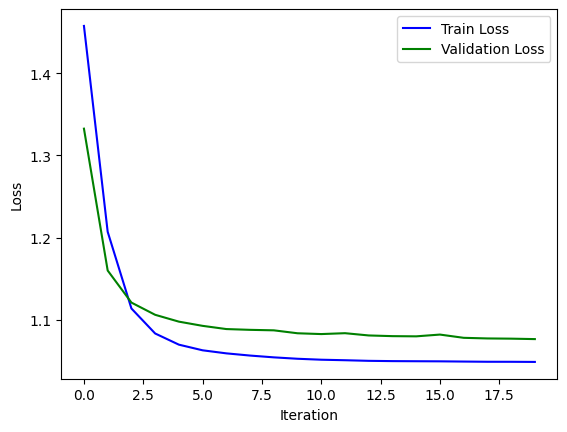

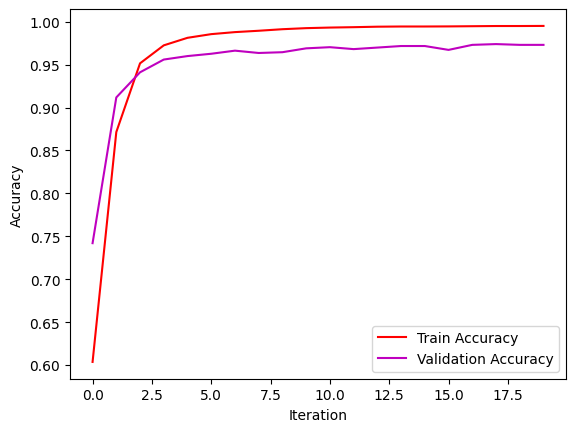

In [169]:
plot_metrics(metrics)

Accuracy: 0.9662771285475793


0.9662771285475793

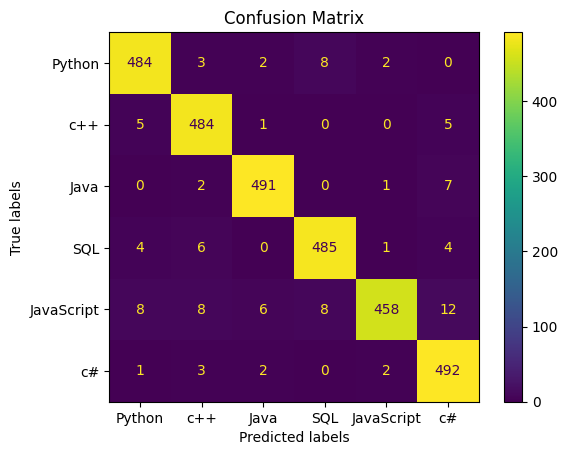

In [170]:
predict(network, test_data, test_labels )